In [276]:
# -*- coding: utf-8 -*-
from datetime import datetime

import warnings
# wilcoxon test has so many future warnings: 
# "FutureWarning: DataFrame.mean and DataFrame.median 
# with numeric_only=None will include datetime64 and 
# datetime64tz columns in a future version."
warnings.simplefilter(action='ignore', category=FutureWarning)

from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates


from matplotlib import rcParams


In [277]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [278]:
# Plot settings
plt.rcParams['figure.figsize'] = [16, 8]

SMALL_SIZE = 16
MEDIUM_SIZE = 19
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
#plt.rc('title', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [279]:

#Data files:
NO_SOUND_DATA = 'data/form-prototype-data.csv'
SOUND_DATA = 'data/sound-comparison-data.csv'
ALIVE_DATA = 'data/alive.csv'

KEYS = ['1. silent', '2. rain', 
        '3. zen', '4. traffic', '5. music']

# Utility functions

In [280]:
def convert_time(row,col='time'):
    time = datetime.strptime(row[col], '%Y-%m-%d %H:%M:%S')
    return time

In [281]:
def convert_encoded_row(row, col):
    time = datetime.strptime(' '.join([row['Date'], row[col]]), '%d.%m.%Y %H:%M:%S')
    return time

def get_duration(row):
    return (row['end'] - row['start']).total_seconds()

def is_use_type(row, codes):
    found = [word for word in codes if(word in row['Keywords'])]
    is_in = bool(found)
    return is_in
    

# Data

In [282]:


# Extract "inside the tunnel" interactions from the data logged from the video recordings
# drop_notin = True drops all events where the monkey is not inside the tunnel
def get_nosound_event_data(filename, drop_notin=True):
    df = pd.read_csv(filename,sep=';', parse_dates=True)
    df['duration'] = df.apply(get_duration, axis=1)
    df['is in'] = df.apply(is_use_inside, axis=1)
    print('before',len(df.index))
    return_df = df[['start', 'end', 'duration', 'Keywords', 'Monkeys']]
    if drop_notin:
        df = df.drop(df[~df['is in']].index)
        return_df = df[['start', 'end', 'duration']]
    print('after',len(df.index))
    
    
    return (return_df, 0)
   

In [283]:
def get_hours(filename):
    alive = pd.read_csv(filename,sep=',',names=['time'], parse_dates=True)
    alive['time'] = alive.apply(convert_time, axis=1)
    alive['hour'] = alive.apply(lambda x: x['time'].hour, axis=1)
    alive = alive.drop(alive[alive['hour'] < 7].index)
    alive = alive.drop(alive[alive['hour'] > 19].index)
    grouped = alive.resample('D', on='time')
    first_hour = grouped.min()['hour'].rename('first_hour')
    last_hour = grouped.max()['hour'].rename('last_hour')

    times = pd.concat([first_hour, last_hour], axis=1).fillna(0)
    times['hours'] = times.apply(lambda row: int(row['last_hour']) - int(row['first_hour']), axis=1)
    return times[['hours', 'first_hour', 'last_hour']]


In [284]:
nosound_events = pd.read_csv(NO_SOUND_DATA,sep=',', parse_dates=True)
nosound_events['start'] = nosound_events.apply(convert_time,axis=1,args=('start',))

final_events = pd.read_csv(SOUND_DATA,sep=',', parse_dates=True).set_index(['name','i'])
# Convert 'start' to date
final_events['start'] = final_events.apply(convert_time,axis=1,args=('start',))
hours_per_day = get_hours(ALIVE_DATA)


# Interactions with the non-functional prototype

In [285]:
def analyse_keywords(events):
    keywords = ['go through', 'go over', 'next to', 'go in', 'sit middle', 'sit on edge', 'on top','bite', 'grab', 'look through', 'food', 'shoo', 'play', 'groom']
    alln = len(events.index)
    print('Total N:', alln)
    
    temp = events.copy()
    
    temp['is in'] = events.apply(is_use_type, args=(['sit on edge', 'sit middle', 'go through'],), axis=1)
    just_in = temp.drop(temp[~temp['is in']].index)
    print('Inside interactions N:', len(just_in), '{:.4f}'.format(100*len(just_in) / float(alln)), '%')
   
    temp['is manip'] = events.apply(is_use_type, args=(['grab', 'bite', 'look through'],), axis=1)
    just_manip = temp.drop(temp[~temp['is manip']].index)
    print('Manipulate interactions N:', len(just_manip), '{:.2f}'.format(100*len(just_manip) / float(alln)), '%')
    
    # This doesn't count other interactions including multiple individuals; actual % for all social interactions
    # is the % of interactions including 2 or more individuals
    temp['is soc'] = events.apply(is_use_type, args=(['groom', 'shoo'],), axis=1)
    just_soc = temp.drop(temp[~temp['is soc']].index)
    print('Social interactions N:', len(just_soc), '{:.2f}'.format(100*len(just_soc) / float(alln)), '%')
    
    temp['is other'] = events.apply(is_use_type, args=(['go over', 'on top', 'next to', 'food'],), axis=1)
    just_other = temp.drop(temp[~temp['is other']].index)
    print('Other interactions N:', len(just_other), '{:.2f}'.format(100*len(just_other) / float(alln)), '%')
    
    print('{: >13} {: >8} {: >6} {: >12} {: >10}'.format('code','%','N', 'Total dur', 'Mean dur'))
    for word in keywords:
        temp['found'] = events.apply(lambda row: True if word in row['Keywords'] else False, axis=1)
        k_events = temp[temp['found'] == True]
        s = k_events['duration'].sum()
        n = len(k_events.index)
        frac = (n/alln)
        # Event avg duration (s/n) causes a warning if n == 0
        print('{: <13}: {:6.2f} %  {:4d}  {:8d} s  {:8.2f} s'.format(word,frac* 100,n, int(s), s/n))
        
        
    print('\nNumber of monkeys:')
    print(events['Monkeys'].value_counts())
    
    

In [286]:
firstdate = datetime.strptime('29-10-2019', '%d-%m-%Y')
untildate = datetime.strptime('16-11-2019', '%d-%m-%Y')

nosound_events_s = nosound_events[(nosound_events['start'] < untildate)]
# Gap at 07/11-09/11 due to lost video recordings
missing_date = '2019-11-07'
nosound_events_start = nosound_events_s[nosound_events_s['date'] != missing_date]
nosound_events_firstday = nosound_events[nosound_events['start'] < firstdate]
thedate = datetime.strptime('11-11-2019', '%d-%m-%Y')
nosound_events_end = nosound_events[nosound_events['start'] > thedate]


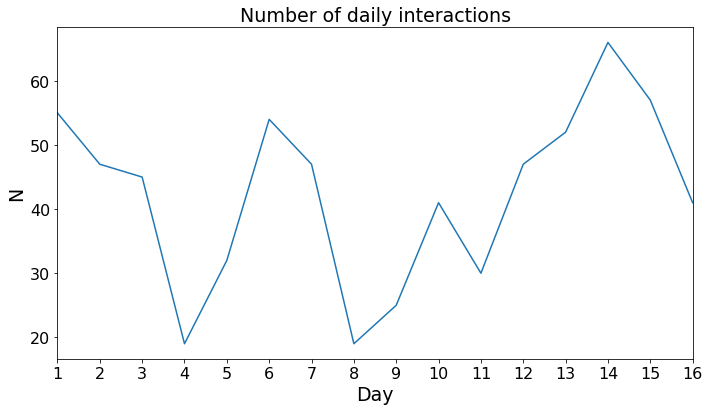

In [287]:
daygroup = nosound_events_start.groupby('date')
durations = daygroup['duration'].count()
# reset index to start at 1
durations.index = np.arange(1, len(durations) + 1)

ax = durations.plot(kind='line', title="Number of daily interactions", figsize=(10,6))
ax.set_ylabel("N")
ax.set_xlabel("Day")
plt.tight_layout()

ax.set_xlim(1, 16)
dim=np.arange(1,17,1)
ax.set_xticks(dim)

fig = ax.get_figure()
fig.savefig("img/initial_daily_interactions.png")


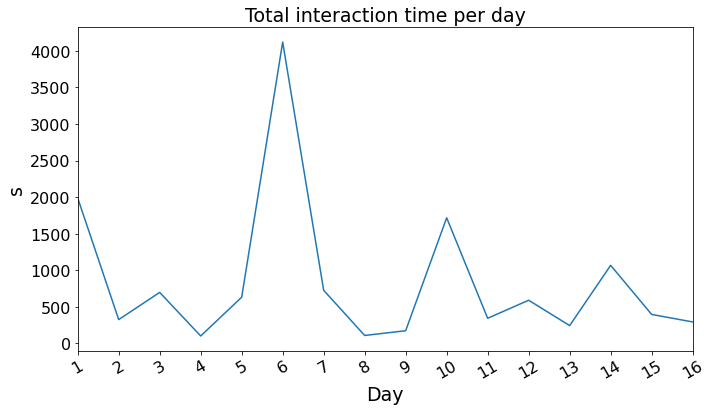

In [288]:
durations_sum = daygroup['duration'].sum()
# reset index to start at 1
durations_sum.index = np.arange(1, len(durations_sum) + 1)
ax=durations_sum.plot(kind='line', title="Total interaction time per day", figsize=(10,6), rot=30)
ax.set_ylabel("s")
ax.set_xlabel("Day")
ax.set_xticks(range(16))
plt.tight_layout()

ax.set_xlim(1, 16)
dim=np.arange(1,17,1)
ax.set_xticks(dim)

fig = ax.get_figure()
fig.savefig("img/initial_daily_interactions_total.png")

In [289]:

analyse_keywords(nosound_events_start)
print('\nMean duration', nosound_events_start['duration'].mean())
print('Median duration', nosound_events_start['duration'].median())
print('Max duration', nosound_events_start['duration'].max())
print('------')


Total N: 677
Inside interactions N: 135 19.9409 %
Manipulate interactions N: 73 10.78 %
Social interactions N: 18 2.66 %
Other interactions N: 578 85.38 %
         code        %      N    Total dur   Mean dur
go through   :  17.73 %   120      2799 s     23.32 s
go over      :  54.95 %   372      3096 s      8.32 s
next to      :   8.12 %    55      1732 s     31.49 s
go in        :   0.44 %     3       111 s     37.00 s
sit middle   :   0.89 %     6      2209 s    368.17 s
sit on edge  :   7.09 %    48      4079 s     84.98 s
on top       :  26.00 %   176      9017 s     51.23 s
bite         :   3.25 %    22      3301 s    150.05 s
grab         :   9.60 %    65      3614 s     55.60 s
look through :   0.44 %     3       910 s    303.33 s
food         :   1.33 %     9       154 s     17.11 s
shoo         :   1.62 %    11       908 s     82.55 s
play         :   0.74 %     5        80 s     16.00 s
groom        :   1.03 %     7      1022 s    146.00 s

Number of monkeys:
1.0    637
2.0 

In [290]:
# Only the first day
analyse_keywords(nosound_events_firstday)
print('\nMean duration', nosound_events_firstday['duration'].mean())
print('Median duration', nosound_events_firstday['duration'].median())
print('Max duration', nosound_events_firstday['duration'].max())
print('------')


Total N: 55
Inside interactions N: 18 32.7273 %
Manipulate interactions N: 25 45.45 %
Social interactions N: 4 7.27 %
Other interactions N: 50 90.91 %
         code        %      N    Total dur   Mean dur
go through   :  20.00 %    11       861 s     78.27 s
go over      :  25.45 %    14       503 s     35.93 s
next to      :  29.09 %    16       573 s     35.81 s
go in        :   1.82 %     1        41 s     41.00 s
sit middle   :   1.82 %     1       401 s    401.00 s
sit on edge  :  21.82 %    12      1298 s    108.17 s
on top       :  47.27 %    26      1630 s     62.69 s
bite         :  18.18 %    10       901 s     90.10 s
grab         :  40.00 %    22      1432 s     65.09 s
look through :   3.64 %     2       298 s    149.00 s
food         :   7.27 %     4        71 s     17.75 s
shoo         :   7.27 %     4        99 s     24.75 s
play         :   0.00 %     0         0 s       nan s
groom        :   0.00 %     0         0 s       nan s

Number of monkeys:
1.0    45
2.0     7

/u/83/piitulr1/unix/miniconda3/envs/monkeysounds-env/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars
/u/83/piitulr1/unix/miniconda3/envs/monkeysounds-env/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars


# Sound comparison analysis

In [291]:
def aggregate_data(events, hours=None, known_hours=False):

    # Some days the system was online only part of the day, get 
    # the correct hours for those instead of the default 12
    def assign_hours(row):
        if row.empty:
            return 0
        date = row.head(1).iloc[0].date().strftime("%Y-%m-%d")
        if date in hours:
            return hours[date]
        else:
            return 12 

 
    grouped = events.groupby('name').resample('D', on='start')
    
    first_hour = grouped['start'].min().rename('first')
    last_hour = grouped['start'].max().rename('last')
    counted = grouped['duration'].count().rename('count')
    summed = grouped['duration'].sum().rename('sum')
    mean = grouped['duration'].mean().rename('mean')
    groupmin = grouped['duration'].min().rename('min')
    groupmax = grouped['duration'].max().rename('max')
    overone = grouped['duration'].apply(lambda x: (x > 1).sum()).rename('count > 1s')
    hours = grouped['start'].apply(assign_hours).rename('hours')

    final_data = pd.concat([first_hour, last_hour, 
                            counted, overone, summed, 
                            mean, groupmin, groupmax, hours], axis=1)

    final_data['count / hour'] = final_data.apply(lambda row: 0 if (float(row['hours'] == 0)) else row['count'] / float(row['hours']), axis=1)
    final_data['count > 1s / hour'] = final_data.apply(lambda row: 0 if (float(row['hours'] == 0)) else row['count > 1s'] / float(row['hours']), axis=1)
    final_data['sum / hours'] = final_data.apply(lambda row: 0 if (row['hours'] == 0) else row['sum'] / row['hours'], axis=1)
    
    # Drop rows that have no data
    final_data = final_data[final_data.hours != 0]
    
    return final_data

In [292]:
final = aggregate_data(final_events.reset_index(), hours=hours_per_day['hours'])
final.groupby('name').sum()

,count,count > 1s,sum,mean,min,max,hours,count / hour,count > 1s / hour,sum / hours
name,,,,,,,,,,
1. silent,116,97,2709,186.955228,9.0,1895.0,63,12.875000,10.041667,238.291667
2. rain,173,143,1080,38.761347,8.0,226.0,73,16.222222,13.638889,99.527778
3. zen,206,159,1670,55.783797,7.0,419.0,79,18.059524,14.023810,148.988095
4. traffic,269,237,7739,176.509147,8.0,2287.0,69,26.166667,23.166667,700.700000
5. music,126,98,1244,71.569128,7.0,709.0,63,13.483333,10.658333,140.016667


## Statistical analysis

In [293]:
# Sum durations by hour

def sum_by_time(events, hours, interval='30min'):

    hours = hours.reset_index()
    hourly = []

    for key in KEYS:
        data = events.loc[key].reset_index(drop=True)
        sample = data.resample(interval, on='start').sum()
        sample_count = data.resample(interval, on='start').count()
        sample['count'] = sample_count['duration']
        sample['meanduration'] = sample.apply(lambda row: row['duration'] / row['count'] if row['count'] > 0 else 0,axis=1)
        sample = sample.reset_index()

        sample = sample.drop(sample[sample['start'].dt.hour < 7].index)
        sample = sample.drop(sample[sample['start'].dt.hour > 18].index)

        for i, row in hours.iterrows():
            date = row['time'].date()
            firsth = row['first_hour']
            lasth = row['last_hour']
            sample = sample.drop(sample[(sample['start'].dt.date == date) & (sample['start'].dt.hour < firsth)].index)
            sample = sample.drop(sample[(sample['start'].dt.date == date) & (sample['start'].dt.hour > lasth)].index)

        hourly.append(sample)

    byhour = pd.concat(hourly, keys=KEYS, names=['name'])
    byhour['starthour'] = byhour.apply(lambda row: row['start'].hour, axis=1)
    
    return byhour


In [294]:
def generate_paired_data(hourly, xname, yname):#, n=4, seed=1):
    hours = range(7, 19)
    xhours = hourly.loc[xname]
    yhours = hourly.loc[yname]
    xdata = []
    ydata = []
    for h in hours:
        xdata.append(xhours[(xhours['starthour'] == h) & (xhours['start'].dt.minute == 0)].mean())
        xdata.append(xhours[(xhours['starthour'] == h) & (xhours['start'].dt.minute ==30)].mean())
        ydata.append(yhours[(yhours['starthour'] == h) & (yhours['start'].dt.minute == 0)].mean())
        ydata.append(yhours[(yhours['starthour'] == h) & (yhours['start'].dt.minute == 30)].mean())
        
    return (pd.concat(xdata, axis=0), pd.concat(ydata))


In [295]:

def wilcox(data, measure):
    p_limit = 0.05

    for i, x in enumerate(KEYS, start=1):
        for y in KEYS:
            if x == y:
                continue
            print(x, 'vs', y)
            xdata, ydata = generate_paired_data(data, x, y)
            n1 = len(xdata[measure])
            n2 = len(ydata[measure])
            
            diff = xdata[measure]-ydata[measure]
            diffdf = pd.DataFrame(diff)
            success = len(diffdf.loc[diffdf[0] > 0])
            ties = len(diffdf.loc[diffdf[0] == 0])
            
            print(x, '(N=',n1,')', 'median:', xdata[measure].median(), 'mean:', xdata[measure].mean())
            print(y, '(N=',n2,')', 'median:', ydata[measure].median(), 'mean:', ydata[measure].mean())
    
            W, p = stats.wilcoxon(xdata[measure], ydata[measure], alternative='greater', zero_method='pratt')

            fract_of_bigger = success / (n1)
            print('W=', W, ', p=', p, 'f=', fract_of_bigger, 'ties=', ties)
            if p < p_limit:
                print('{} is greater than {}! \n'.format(x, y))
            else:
                print('No difference \n')


            print('----')


In [296]:
# Wilcoxon paired test for mean duration in 30 min intervals
 
byhour = sum_by_time(final_events,hours_per_day)
wilcox(byhour, 'duration')


1. silent vs 2. rain
1. silent (N= 24 ) median: 4.383333333333333 mean: 21.825000000000003
2. rain (N= 24 ) median: 5.2 mean: 7.7063492063492065
W= 155.5 , p= 0.43193307774264444 f= 0.4166666666666667 ties= 1
No difference 

----
1. silent vs 3. zen


/u/83/piitulr1/unix/miniconda3/envs/monkeysounds-env/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/u/83/piitulr1/unix/miniconda3/envs/monkeysounds-env/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


1. silent (N= 24 ) median: 4.383333333333333 mean: 21.825000000000003
3. zen (N= 24 ) median: 5.0 mean: 10.857638888888891
W= 141.0 , p= 0.5959515670922135 f= 0.3333333333333333 ties= 1
No difference 

----
1. silent vs 4. traffic
1. silent (N= 24 ) median: 4.383333333333333 mean: 21.825000000000003
4. traffic (N= 24 ) median: 12.583333333333334 mean: 56.36388888888888
W= 66.0 , p= 0.9914826463216715 f= 0.20833333333333334 ties= 1
No difference 

----
1. silent vs 5. music


/u/83/piitulr1/unix/miniconda3/envs/monkeysounds-env/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


1. silent (N= 24 ) median: 4.383333333333333 mean: 21.825000000000003
5. music (N= 24 ) median: 4.726190476190476 mean: 10.714186507936509
W= 140.0 , p= 0.6158518195152283 f= 0.4583333333333333 ties= 0
No difference 

----
2. rain vs 1. silent
2. rain (N= 24 ) median: 5.2 mean: 7.7063492063492065
1. silent (N= 24 ) median: 4.383333333333333 mean: 21.825000000000003
W= 143.5 , p= 0.5680669222573556 f= 0.5416666666666666 ties= 1
No difference 

----
2. rain vs 3. zen


/u/83/piitulr1/unix/miniconda3/envs/monkeysounds-env/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/u/83/piitulr1/unix/miniconda3/envs/monkeysounds-env/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


2. rain (N= 24 ) median: 5.2 mean: 7.7063492063492065
3. zen (N= 24 ) median: 5.0 mean: 10.857638888888891
W= 121.5 , p= 0.7881800802596396 f= 0.3333333333333333 ties= 1
No difference 

----
2. rain vs 4. traffic
2. rain (N= 24 ) median: 5.2 mean: 7.7063492063492065
4. traffic (N= 24 ) median: 12.583333333333334 mean: 56.36388888888888
W= 61.0 , p= 0.9942778194027345 f= 0.2916666666666667 ties= 1
No difference 

----
2. rain vs 5. music


/u/83/piitulr1/unix/miniconda3/envs/monkeysounds-env/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/u/83/piitulr1/unix/miniconda3/envs/monkeysounds-env/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


2. rain (N= 24 ) median: 5.2 mean: 7.7063492063492065
5. music (N= 24 ) median: 4.726190476190476 mean: 10.714186507936509
W= 143.0 , p= 0.5736804538313957 f= 0.4583333333333333 ties= 1
No difference 

----
3. zen vs 1. silent
3. zen (N= 24 ) median: 5.0 mean: 10.857638888888891
1. silent (N= 24 ) median: 4.383333333333333 mean: 21.825000000000003
W= 158.0 , p= 0.4040484329077865 f= 0.625 ties= 1
No difference 

----
3. zen vs 2. rain


/u/83/piitulr1/unix/miniconda3/envs/monkeysounds-env/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/u/83/piitulr1/unix/miniconda3/envs/monkeysounds-env/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


3. zen (N= 24 ) median: 5.0 mean: 10.857638888888891
2. rain (N= 24 ) median: 5.2 mean: 7.7063492063492065
W= 177.5 , p= 0.2118199197403604 f= 0.625 ties= 1
No difference 

----
3. zen vs 4. traffic
3. zen (N= 24 ) median: 5.0 mean: 10.857638888888891
4. traffic (N= 24 ) median: 12.583333333333334 mean: 56.36388888888888
W= 49.0 , p= 0.9979597342796109 f= 0.2916666666666667 ties= 1
No difference 

----
3. zen vs 5. music


/u/83/piitulr1/unix/miniconda3/envs/monkeysounds-env/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


3. zen (N= 24 ) median: 5.0 mean: 10.857638888888891
5. music (N= 24 ) median: 4.726190476190476 mean: 10.714186507936509
W= 173.0 , p= 0.26352953910827637 f= 0.5833333333333334 ties= 0
No difference 

----
4. traffic vs 1. silent
4. traffic (N= 24 ) median: 12.583333333333334 mean: 56.36388888888888
1. silent (N= 24 ) median: 4.383333333333333 mean: 21.825000000000003
W= 233.0 , p= 0.008517353678328473 f= 0.75 ties= 1
4. traffic is greater than 1. silent! 

----
4. traffic vs 2. rain


/u/83/piitulr1/unix/miniconda3/envs/monkeysounds-env/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/u/83/piitulr1/unix/miniconda3/envs/monkeysounds-env/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


4. traffic (N= 24 ) median: 12.583333333333334 mean: 56.36388888888888
2. rain (N= 24 ) median: 5.2 mean: 7.7063492063492065
W= 238.0 , p= 0.005722180597265479 f= 0.6666666666666666 ties= 1
4. traffic is greater than 2. rain! 

----
4. traffic vs 3. zen
4. traffic (N= 24 ) median: 12.583333333333334 mean: 56.36388888888888
3. zen (N= 24 ) median: 5.0 mean: 10.857638888888891
W= 250.0 , p= 0.002040265720389106 f= 0.6666666666666666 ties= 1
4. traffic is greater than 3. zen! 

----
4. traffic vs 5. music


/u/83/piitulr1/unix/miniconda3/envs/monkeysounds-env/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


4. traffic (N= 24 ) median: 12.583333333333334 mean: 56.36388888888888
5. music (N= 24 ) median: 4.726190476190476 mean: 10.714186507936509
W= 226.0 , p= 0.014565646648406982 f= 0.625 ties= 0
4. traffic is greater than 5. music! 

----
5. music vs 1. silent
5. music (N= 24 ) median: 4.726190476190476 mean: 10.714186507936509
1. silent (N= 24 ) median: 4.383333333333333 mean: 21.825000000000003
W= 160.0 , p= 0.39491891860961914 f= 0.5416666666666666 ties= 0
No difference 

----
5. music vs 2. rain
5. music (N= 24 ) median: 4.726190476190476 mean: 10.714186507936509
2. rain (N= 24 ) median: 5.2 mean: 7.7063492063492065
W= 156.0 , p= 0.42631954616860435 f= 0.5 ties= 1
No difference 

----
5. music vs 3. zen
5. music (N= 24 ) median: 4.726190476190476 mean: 10.714186507936509
3. zen (N= 24 ) median: 5.0 mean: 10.857638888888891
W= 127.0 , p= 0.7456169724464417 f= 0.4166666666666667 ties= 0
No difference 

----
5. music vs 4. traffic


/u/83/piitulr1/unix/miniconda3/envs/monkeysounds-env/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


5. music (N= 24 ) median: 4.726190476190476 mean: 10.714186507936509
4. traffic (N= 24 ) median: 12.583333333333334 mean: 56.36388888888888
W= 74.0 , p= 0.9865361452102661 f= 0.375 ties= 0
No difference 

----


## Figures and descriptive stats

In [297]:
def basic_plot(data):
    ax1 = data.unstack(level=0).plot(y='sum / hours',kind='line', title='Average total interaction time per hour', figsize=(10,6))
    ax1.set_ylabel('seconds')
    #data.unstack(level=0).plot(y='sum > 1s / hours',kind='line', title='Average total interaction time per hour (> 1s)')
    ax2 = data.unstack(level=0).plot(y='count / hour',kind='line', title='Average number or interactions per hour', figsize=(10,6))
    ax2.set_ylabel('number')
    
    dim=np.arange(1,8,1)
    for ax in [ax1, ax2]:
        ax.set_xticks(range(8))
        ax.set_xlim(1, 7)
        ax.set_xticks(dim)
        
        ax.legend(['Silent', 'Rain', 'Zen', 'Traffic', 'Music'])
 

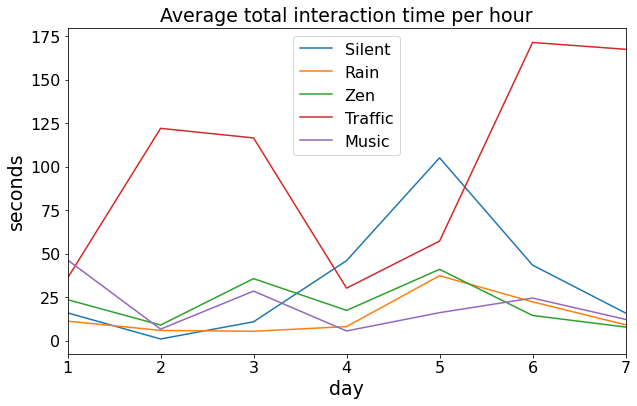

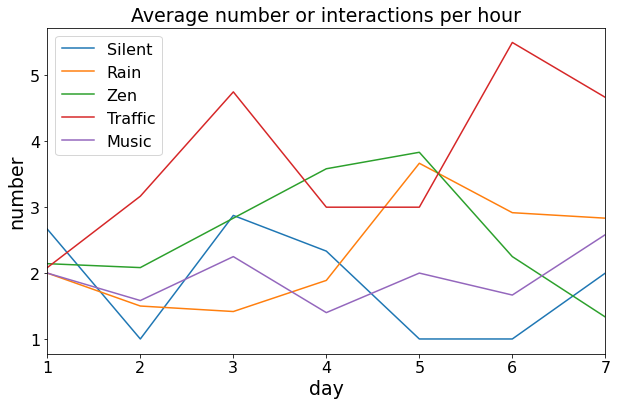

In [298]:

final.index = pd.MultiIndex.from_arrays(
    [final.index.get_level_values(0), final.groupby(level=0).cumcount() + 1],
    names=['name', 'day'])

basic_plot(final)

### Descriptive stats

In [299]:
#Normality test
k2, p = stats.normaltest(final_events['duration'].values)
if p < 0.001:
    # Reject the null hypothesis that data is normal
    print("Data is not normal, p = {:.10f}".format(p))
else:
    print("Data is normal, p = ", p)

Data is not normal, p = 0.0000000000


In [300]:
# Table 4: mean, std, min, max
final_events['duration'].groupby('name').describe()

,count,mean,std,min,25%,50%,75%,max
name,,,,,,,,
1. silent,116.0,23.353448,107.499100,1.0,2.0,4.0,7.00,1052.0
2. rain,173.0,6.242775,11.399154,1.0,2.0,4.0,7.00,116.0
3. zen,206.0,8.106796,16.072648,1.0,2.0,3.0,6.75,141.0
4. traffic,269.0,28.769517,73.789680,1.0,2.0,6.0,22.00,882.0
5. music,126.0,9.873016,33.285909,1.0,2.0,3.0,5.00,307.0


In [301]:
# Table 4: median
final_events['duration'].groupby('name').median()

name
1. silent     4
2. rain       4
3. zen        3
4. traffic    6
5. music      3
Name: duration, dtype: int64

### Additional measures

- sum durations / hour
- count interactions / hour
- mean interc

In [302]:
# Table 4: no. per hour and total use per hour
temp = final
# Total count/sum/hours per condition
temp = temp[['count', 'sum', 'hours']].groupby('name').sum()
temp['count / h'] = temp.apply(lambda row: row['count'] / row['hours'],axis=1)
temp['total duration / h'] = temp.apply(lambda row: row['sum'] / row['hours'],axis=1)
temp['mean duration'] = temp.apply(lambda row: row['sum'] / row['count'],axis=1)
temp[['count / h', 'total duration / h', 'mean duration', 'hours']]
temp

,count,sum,hours,count / h,total duration / h,mean duration
name,,,,,,
1. silent,116,2709,63,1.841270,43.000000,23.353448
2. rain,173,1080,73,2.369863,14.794521,6.242775
3. zen,206,1670,79,2.607595,21.139241,8.106796
4. traffic,269,7739,69,3.898551,112.159420,28.769517
5. music,126,1244,63,2.000000,19.746032,9.873016
